## Load the dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt



# Load the normalized dataset
file_path = '../Normalization/A1-turbine-normalized.csv'  # Update this to the path of your normalized dataset
normalized_data = pd.read_csv(file_path)

X = normalized_data.iloc[:, :-1].values  # Select all columns except the last as features
y = normalized_data.iloc[:, -1].values  # Select the last column as the target

# Split data into training and test parts
# This is an example split, adjust the test_size as needed for your experiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## NeuralNetwork class

In [2]:
# Neural Network class


class MyNeuralNetwork:
  def __init__(self, layers, learning_rate, momentum, activation, validation_percentage=0):
    self.L = len(layers)    # number of layers
    self.n = layers.copy()  # number of neurons in each layer

    self.h = []             # pre-activation fields
    for lay in range(self.L):
      self.h.append(np.zeros(layers[lay]))

    self.xi = []            # node values (activations)
    for lay in range(self.L):
      self.xi.append(np.zeros(layers[lay]))

    self.w = []             # edge weights
    self.w = [np.random.randn(layers[i], layers[i-1]) for i in range(1, self.L)]

    for lay in range(1, self.L):
      self.w.append(np.random.randn(layers[lay], layers[lay - 1]))  # random weights for other layers

    self.theta = []         # threshold values
    for lay in range(self.L):
      self.theta.append(np.zeros(layers[lay]))

    self.delta = []         # error term for each neuron
    for lay in range(self.L):
      self.delta.append(np.zeros(layers[lay]))

    self.d_w = []           # change in weights for backpropagation
    for w in self.w:
      self.d_w.append(np.zeros_like(w))

    self.d_theta = []       # change in thresholds for backpropagation
    for t in self.theta:
      self.d_theta.append(np.zeros_like(t))

    self.d_w_prev = []      # previous change in weights for momentum
    for w in self.w:
      self.d_w_prev.append(np.zeros_like(w))

    self.d_theta_prev = []  # previous change in thresholds for momentum
    for t in self.theta:
      self.d_theta_prev.append(np.zeros_like(t))

    self.learning_rate = learning_rate  # learning rate
    self.momentum = momentum            # momentum factor
    self.activation = activation        # name of the activation function
    self.validation_percentage = validation_percentage  # validation set percentage
    self.loss_epochs = []               # loss per epoch for tracking

  def activation_function(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'linear':
            return x
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Invalid activation function")

  def activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.activation == 'linear':
            return 1
        elif self.activation == 'tanh':
            return 1 - x**2
        else:
            raise ValueError("Invalid activation function")

  def propagate_forward(self, inputs):
        # forward propagation through the network
        self.xi[0] = inputs
        for layer in range(1, self.L):
            net_input = np.dot(self.w[layer - 1], self.xi[layer - 1]) - self.theta[layer]
            self.xi[layer] = self.activation_function(net_input)

  def propagate_backward(self, target):
    # Calculate delta for the output layer
    self.delta[-1] = (self.xi[-1] - target) * self.activation_derivative(self.xi[-1])

    # Propagate the delta backward through the network
    for layer in reversed(range(1, self.L - 1)):
      
        # This line is causing the error, so we inspect the shapes right before it's executed
        self.delta[layer] = np.dot(self.w[layer].T, self.delta[layer + 1]) * self.activation_derivative(self.xi[layer])

  def adjust_weights(self):
        # update the weights and thresholds
        for layer in range(1, self.L):
            gradient_w = self.learning_rate * np.outer(self.delta[layer], self.xi[layer - 1]) + self.momentum * self.d_w_prev[layer - 1]
            gradient_theta = self.learning_rate * self.delta[layer] + self.momentum * self.d_theta_prev[layer]

            self.w[layer - 1] -= gradient_w
            self.theta[layer] -= gradient_theta

            self.d_w_prev[layer - 1] = gradient_w
            self.d_theta_prev[layer] = gradient_theta

  def mape(self, actual, predicted):
        """
        Calculate the Mean Absolute Percentage Error (MAPE)

        Parameters:
        - actual: np.array, the actual observed values.
        - predicted: np.array, the predicted values corresponding to the actual values.

        Returns:
        - mape: float, the MAPE value as a percentage.
        """
        actual, predicted = np.array(actual), np.array(predicted)
        non_zero = np.where(actual != 0, actual, np.finfo(float).eps)  #to avoid division by zero
        return 100 * np.mean(np.abs((actual - predicted) / non_zero))


  def fit(self, input_data, target_data, total_epochs, batch_size=32, decay_rate=0.1):
    # Split data into training and test parts
    train_inputs, test_inputs, train_targets, test_targets = train_test_split(input_data, target_data, test_size=self.validation_percentage, shuffle=True, random_state=42)
    
    # Normalize the input features
    feature_scaler = StandardScaler()
    train_inputs = feature_scaler.fit_transform(train_inputs)
    test_inputs = feature_scaler.transform(test_inputs)

    epoch_losses = []

    for epoch_idx in range(total_epochs):
        # Iterate over batches
        for start_idx in np.arange(0, len(train_inputs), batch_size):
            selected_idxs = np.random.randint(0, len(train_inputs), size=batch_size)
            batch_inputs = train_inputs[selected_idxs]
            batch_targets = train_targets[selected_idxs]

            # Training on each batch
            for input_sample, target_sample in zip(batch_inputs, batch_targets):
                self.propagate_forward(input_sample)
                self.propagate_backward(target_sample)
                self.adjust_weights()

            # Error and MAPE calculation after processing the batch
            predictions_train = self.predict(train_inputs)
            error_train = np.mean(np.square(predictions_train - train_targets))
            mape_train = self.mape(train_targets, predictions_train)

            predictions_test = self.predict(test_inputs)
            error_test = np.mean(np.square(predictions_test - test_targets))
            mape_test = self.mape(test_targets, predictions_test)

            epoch_losses.append([error_train, error_test, mape_train, mape_test])

            # Periodic logging
            if (epoch_idx + 1) % 10 == 0:
                print(f"Epoch {epoch_idx + 1}/{total_epochs} - Train Error: {error_train}, Test Error: {error_test}, Train MAPE: {mape_train}, Test MAPE: {mape_test}")

        # Adjust the learning rate based on the decay
        self.learning_rate *= (1 / (1 + decay_rate * epoch_idx))

    # Final performance metrics
    mape_final_train = self.mape(train_targets, self.predict(train_inputs))
    mape_final_test = self.mape(test_targets, self.predict(test_inputs))
    print(f"Final Train MAPE: {mape_final_train}, Final Test MAPE: {mape_final_test}")

    return np.array(epoch_losses)


  def predict(self, X):
        """
        Predict the output for each sample in X.

        Parameters:
        - X: np.array, shape (n_samples, n_features), input samples.

        Returns:
        - predictions: np.array, predicted values for all the input samples.
        """
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)

        for i in range(n_samples):
            # forward pass to get the prediction for the i-th sample
            self.propagate_forward(X[i])
            # assuming the output is the activation of the last layer
            predictions[i] = self.xi[-1]

        return predictions



  def loss_epochs(self):
        """
        Return the evolution of the training and validation errors per epoch.

        Returns:
        - A tuple of two arrays: (training_errors, validation_errors).
          Each array has size (n_epochs,).
        """
        return np.array(self.training_errors), np.array(self.validation_errors)




## Defining the neural network

In [3]:

# Define neural network parameters with two hidden layers
layers = [4, 10, 5, 1]  # Example: 4 input features, two hidden layers with 10 and 5 neurons, and 1 output neuron for regression
learning_rate = 0.01
momentum = 0.9
activation = 'sigmoid'  # Adjust the activation function as per your requirement
validation_percentage = 0.2  # 20% of the data will be used for validation
epochs = 100


# Configuration 2: Increased learning rate decreased momentum and changed layers
layers2 = [4, 8, 4, 1]
learning_rate2 = 0.05  # Higher learning rate
momentum2 = 0.7

# Configuration 3: Decreased momentum, high learning rate, and more neurons in the layer
layers3 = [4, 12, 6, 1]
learning_rate3 = 0.1
momentum3 = 0.3

# Training with Configuration 1
nn_config1 = MyNeuralNetwork(layers, learning_rate, momentum, activation, validation_percentage)
loss_history_config1 = nn_config1.fit(X_train, y_train, epochs)

# Training with Configuration 2 (Using original layer configuration for comparison)
nn_config2 = MyNeuralNetwork(layers2, learning_rate2, momentum2, activation, validation_percentage)
loss_history_config2 = nn_config2.fit(X_train, y_train, epochs)

# Training with Configuration 3 (Using original layer configuration for comparison)
nn_config3 = MyNeuralNetwork(layers3, learning_rate3, momentum3, activation, validation_percentage)
loss_history_config3 = nn_config3.fit(X_train, y_train, epochs)





Epoch 10/100 - Train Error: 0.6341227094612324, Test Error: 0.7048660777635736, Train MAPE: 93.45343838906943, Test MAPE: 87.96942263494073
Epoch 10/100 - Train Error: 0.6341101631815143, Test Error: 0.7048602207769173, Train MAPE: 93.44332562461528, Test MAPE: 87.96584220681099
Epoch 10/100 - Train Error: 0.6341090098346569, Test Error: 0.7048644373535689, Train MAPE: 93.44124484529763, Test MAPE: 87.96787203911524
Epoch 10/100 - Train Error: 0.6340935601869916, Test Error: 0.7048538154129345, Train MAPE: 93.43443531746513, Test MAPE: 87.96629668729533
Epoch 10/100 - Train Error: 0.6340807482060078, Test Error: 0.7048517642819955, Train MAPE: 93.40192645433922, Test MAPE: 87.94555853282358
Epoch 10/100 - Train Error: 0.6340776611957362, Test Error: 0.7048609328056911, Train MAPE: 93.34984730627035, Test MAPE: 87.90863279865818
Epoch 10/100 - Train Error: 0.6340573702547737, Test Error: 0.7048520360984847, Train MAPE: 93.30389745709876, Test MAPE: 87.87712616919988
Epoch 10/100 - Train

## Training and validation error

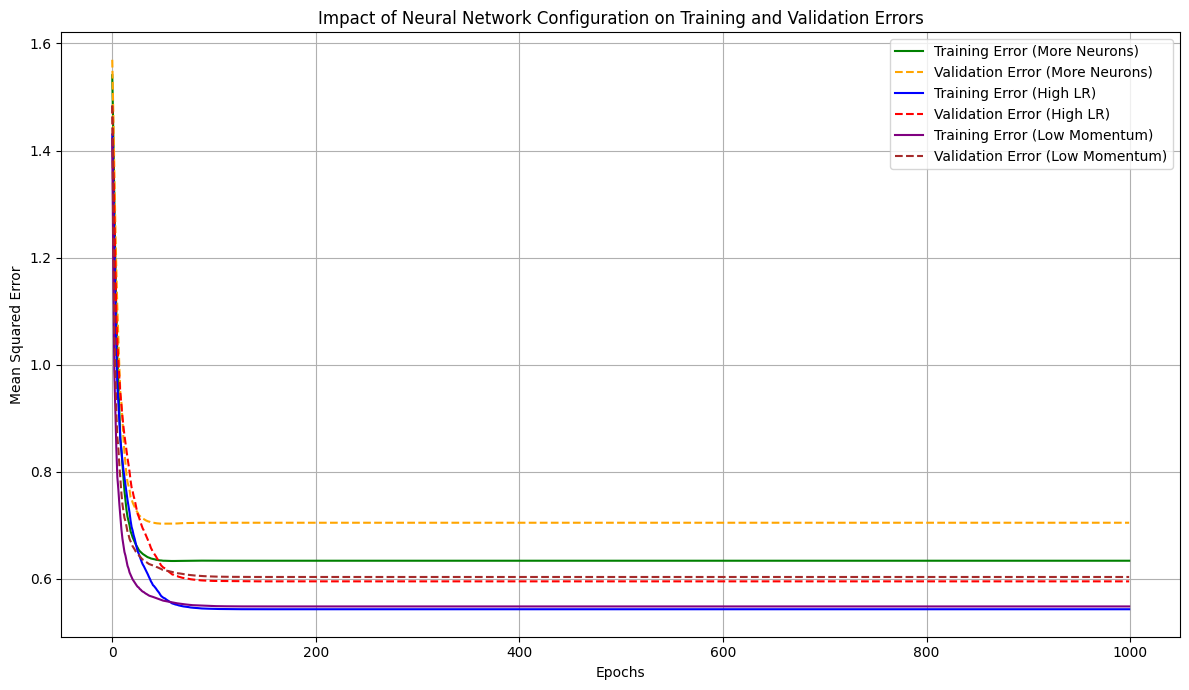

In [4]:
# Plotting the results
plt.figure(figsize=(12, 7))

# Configuration 1 errors
train_errors_config1 = loss_history_config1[:, 0]
val_errors_config1 = loss_history_config1[:, 1]
plt.plot(train_errors_config1, label='Training Error (More Neurons)', linestyle='-', color='green')
plt.plot(val_errors_config1, label='Validation Error (More Neurons)', linestyle='--', color='orange')

# Configuration 2 errors
train_errors_config2 = loss_history_config2[:, 0]
val_errors_config2 = loss_history_config2[:, 1]
plt.plot(train_errors_config2, label='Training Error (High LR)', linestyle='-', color='blue')
plt.plot(val_errors_config2, label='Validation Error (High LR)', linestyle='--', color='red')

# Configuration 3 errors
train_errors_config3 = loss_history_config3[:, 0]
val_errors_config3 = loss_history_config3[:, 1]
plt.plot(train_errors_config3, label='Training Error (Low Momentum)', linestyle='-', color='purple')
plt.plot(val_errors_config3, label='Validation Error (Low Momentum)', linestyle='--', color='brown')

# Annotations and labels
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Impact of Neural Network Configuration on Training and Validation Errors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Scatter plot

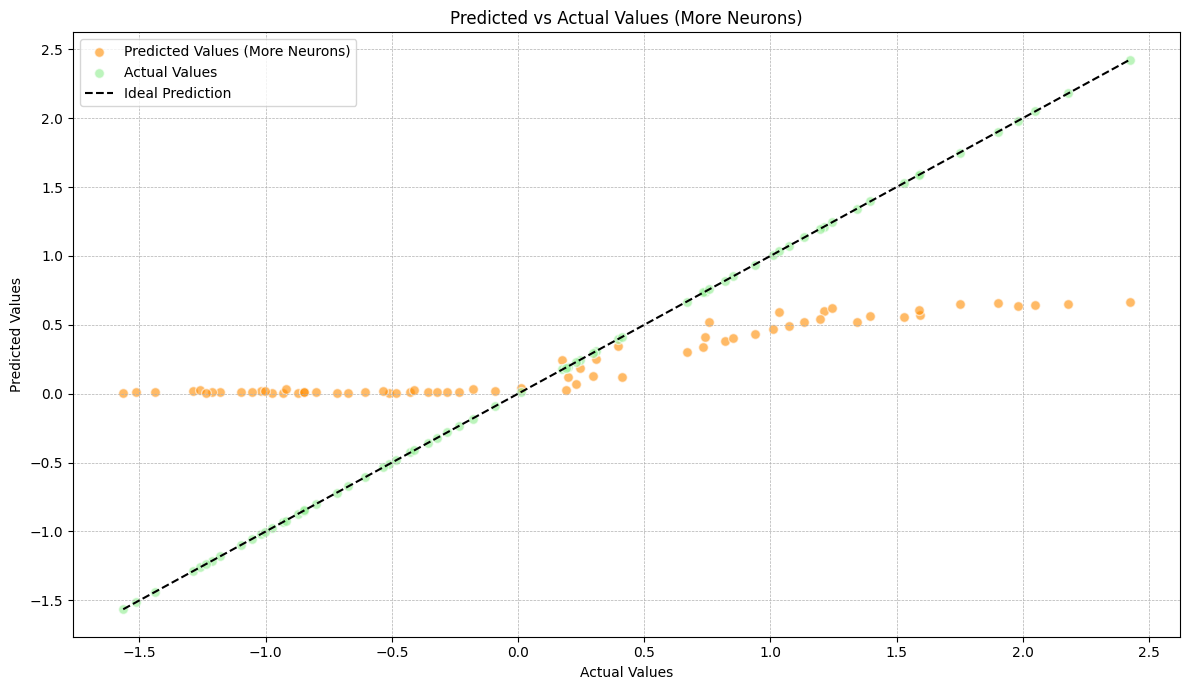

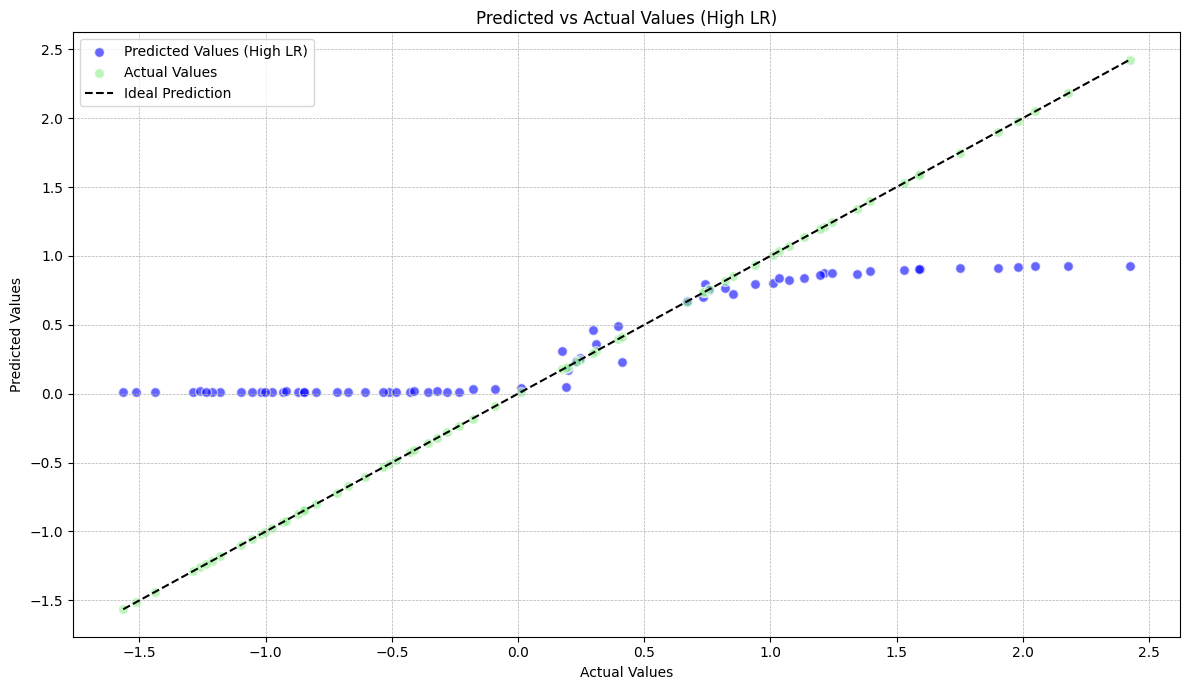

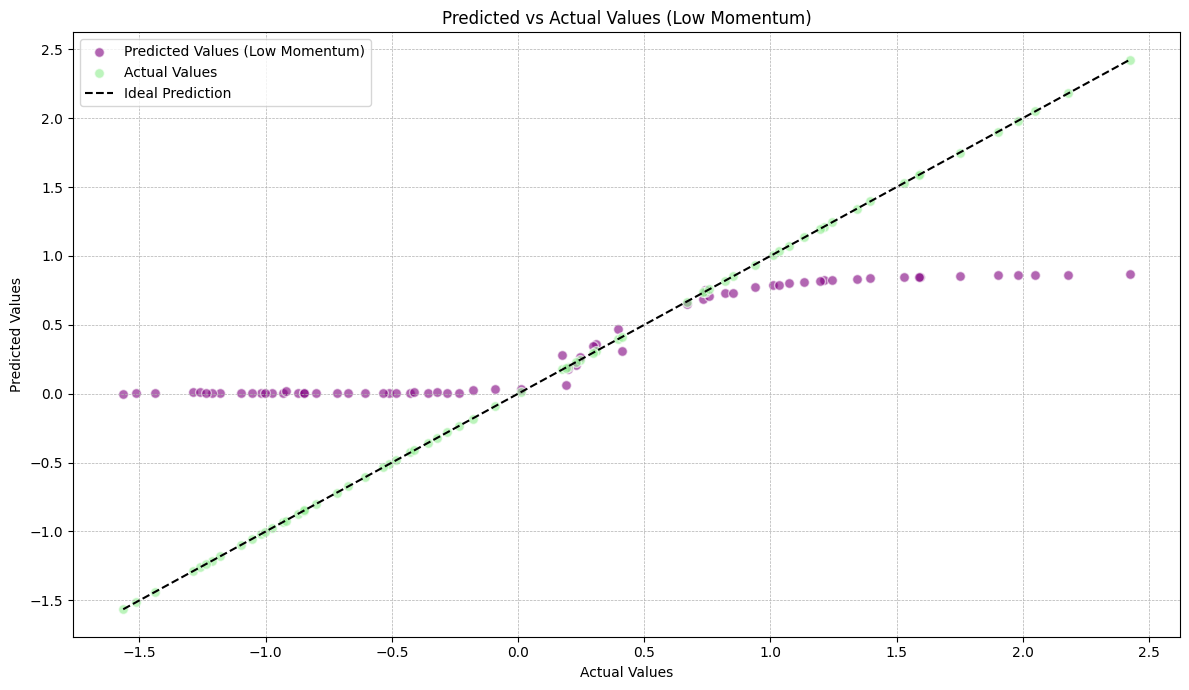

In [5]:
# Generating predictions for each configuration
predictions_config1 = nn_config1.predict(X_test)
predictions_config2 = nn_config2.predict(X_test)
predictions_config3 = nn_config3.predict(X_test)

# Scatter plot for Configuration 1: Increased neurons in hidden layers
plt.figure(figsize=(12, 7))
plt.scatter(y_test, predictions_config1, color='darkorange', label='Predicted Values (More Neurons)', alpha=0.6, edgecolors='w', s=50)
plt.scatter(y_test, y_test, color='lightgreen', label='Actual Values', alpha=0.6, edgecolors='w', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (More Neurons)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Scatter plot for Configuration 2: Increased learning rate
plt.figure(figsize=(12, 7))
plt.scatter(y_test, predictions_config2, color='blue', label='Predicted Values (High LR)', alpha=0.6, edgecolors='w', s=50)
plt.scatter(y_test, y_test, color='lightgreen', label='Actual Values', alpha=0.6, edgecolors='w', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (High LR)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Scatter plot for Configuration 3: Decreased momentum
plt.figure(figsize=(12, 7))
plt.scatter(y_test, predictions_config3, color='purple', label='Predicted Values (Low Momentum)', alpha=0.6, edgecolors='w', s=50)
plt.scatter(y_test, y_test, color='lightgreen', label='Actual Values', alpha=0.6, edgecolors='w', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Low Momentum)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
